### 1. Setup and Configuration
Imports necessary libraries, defines file paths, sets the time window for the full year of 2018, and defines a helper class to handle sparse matrices in the pipeline.


In [87]:
from pathlib import Path
from typing import List, Tuple, Dict

import json
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import joblib
import matplotlib.pyplot as plt

import requests
import holidays


# -------------------------
# Input
# -------------------------
DATA_PATH = Path("bike_data_clean.parquet")

# Train on ALL clusters, but only write preds for these (keeps notebooks fast)
CLUSTERS_TO_PREDICT = [0, 8]

# -------------------------
# Output
# -------------------------
ART_DIR = Path("artifacts_mlp")
PRED_DIR = Path("preds_mlp")
ART_DIR.mkdir(parents=True, exist_ok=True)
PRED_DIR.mkdir(parents=True, exist_ok=True)

# -------------------------
# Time split
# -------------------------
VAL_START  = pd.to_datetime("2018-11-01")
VAL_END    = pd.to_datetime("2018-12-01")  # exclusive
TEST_START = pd.to_datetime("2018-12-01")  # test = Dec onward

# Full-year window (CRITICAL FIX)
START_TIME = pd.Timestamp("2018-01-01 00:00:00")
END_TIME   = pd.Timestamp("2018-12-31 23:00:00")

# Feature columns
NUM_FEATS = ['lag_1','lag_24','lag_168','rmean_3h','rmean_24h']
CAT_FEATS = ['hour','weekday','gmm20_cluster']
FEATURES = NUM_FEATS + CAT_FEATS

# Weather features
NYC_LAT = 40.7128
NYC_LON = -74.0060
WEATHER_TZ = "America/New_York"
WEATHER_CACHE = ART_DIR / "weather_nyc_2018_hourly.parquet"

EPS = 1e-6

class DenseTransformer(TransformerMixin, BaseEstimator):
    """MLPRegressor doesn't like sparse matrices in many sklearn versions."""
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        try:
            return X.toarray()
        except Exception:
            return X

assert DATA_PATH.exists(), f"Missing {DATA_PATH}"
print("[OK] Config set.")
print("[INFO] Window:", START_TIME, "to", END_TIME)
print("[INFO] Val:", VAL_START, "to", VAL_END, "(exclusive)")
print("[INFO] Test from:", TEST_START)


[OK] Config set.
[INFO] Window: 2018-01-01 00:00:00 to 2018-12-31 23:00:00
[INFO] Val: 2018-11-01 00:00:00 to 2018-12-01 00:00:00 (exclusive)
[INFO] Test from: 2018-12-01 00:00:00


### 2. Data Aggregation
Aggregating raw trip data into hourly time series (pickups and dropoffs) for the specified clusters, ensuring a continuous time grid including hours with zero activity.


In [88]:
# ------------------------------------------------------------
# Hourly demand per cluster (2018 only)
# ------------------------------------------------------------

def build_hourly_demand_for_cluster(df: pd.DataFrame, cluster_id: int) -> pd.DataFrame:
    """Build an hourly demand table for a specific cluster.

    Output: DataFrame with columns:
        - date (datetime, normalized)
        - hour (0..23)
        - pickups  (trips starting in this cluster)
        - dropoffs (trips ending in this cluster)
        - cluster_id
    restricted to the global [START_TIME, END_TIME] window.
    """
    df_pick = df[df["gmm20_cluster"] == cluster_id]
    df_drop = df[df["end_gmm20_cluster"] == cluster_id]

    if df_pick.empty and df_drop.empty:
        raise ValueError(f"No trip data for cluster {cluster_id}")

    # --- Pickups ---
    pick_group = (
        df_pick
        .groupby(["start_date", "start_hour"])
        .size()
        .rename("pickups")
        .reset_index()
    )

    # --- Dropoffs ---
    drop_group = (
        df_drop
        .groupby(["stop_date", "stop_hour"])
        .size()
        .rename("dropoffs")
        .reset_index()
    )

    # Normalize to (date, hour)
    pick_group = pick_group.rename(
        columns={"start_date": "date", "start_hour": "hour"}
    )
    drop_group = drop_group.rename(
        columns={"stop_date": "date", "stop_hour": "hour"}
    )

    pick_group["date"] = pd.to_datetime(pick_group["date"]).dt.normalize()
    drop_group["date"] = pd.to_datetime(drop_group["date"]).dt.normalize()

    # Restrict to global window
    min_date = START_TIME.normalize()
    max_date = END_TIME.normalize()
    pick_group = pick_group[(pick_group["date"] >= min_date) & (pick_group["date"] <= max_date)]
    drop_group = drop_group[(drop_group["date"] >= min_date) & (drop_group["date"] <= max_date)]

    # Full grid of dates × hours
    all_dates = pd.date_range(min_date, max_date, freq="D")
    hours = np.arange(24)
    idx = pd.MultiIndex.from_product([all_dates, hours], names=["date", "hour"])
    hourly = pd.DataFrame(index=idx).reset_index()

    # Join pickups and dropoffs
    hourly = hourly.merge(pick_group, on=["date", "hour"], how="left")
    hourly = hourly.merge(drop_group, on=["date", "hour"], how="left")

    hourly["pickups"] = hourly["pickups"].fillna(0).astype("float32")
    hourly["dropoffs"] = hourly["dropoffs"].fillna(0).astype("float32")

    hourly["cluster_id"] = int(cluster_id)

    return hourly


#### Fetching weather data for the model and storing it

In [89]:
def fetch_open_meteo_hourly(lat, lon, start="2018-01-01", end="2018-12-31", tz="America/New_York"):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start,
        "end_date": end,
        "hourly": ",".join([
            "temperature_2m",
            "precipitation",
            "rain",
            "snowfall",
            "windspeed_10m",
            "cloudcover",
            "weathercode",
        ]),
        "timezone": tz,
    }
    r = requests.get(url, params=params, timeout=120)
    r.raise_for_status()
    j = r.json()
    df = pd.DataFrame(j["hourly"])
    df["timestamp"] = pd.to_datetime(df["time"])   # already in tz you requested
    df = df.drop(columns=["time"])
    # make timestamps naive to match your bike timestamps (assumed local)
    df["timestamp"] = df["timestamp"].dt.tz_localize(None) if df["timestamp"].dt.tz is not None else df["timestamp"]
    return df

def load_weather_2018():
    if WEATHER_CACHE.exists():
        w = pd.read_parquet(WEATHER_CACHE)
        w["timestamp"] = pd.to_datetime(w["timestamp"])
        return w
    w = fetch_open_meteo_hourly(NYC_LAT, NYC_LON, "2018-01-01", "2018-12-31", WEATHER_TZ)
    w.to_parquet(WEATHER_CACHE, index=False)
    print("[OK] cached weather ->", WEATHER_CACHE)
    return w

weather_hourly = load_weather_2018()
print("[INFO] weather_hourly:", weather_hourly.shape, weather_hourly["timestamp"].min(), weather_hourly["timestamp"].max())


[INFO] weather_hourly: (8760, 8) 2018-01-01 00:00:00 2018-12-31 23:00:00


### 3. Feature Engineering
Generating lag features (1h, 24h, 1 week) and rolling means to capture temporal dependencies and seasonality in the data.

In [90]:
# ------------------------------------------------------------
# Supervised Dataset (Day d -> Day d+1, multi-output 24h)
# ------------------------------------------------------------

def build_supervised_from_hourly(
    hourly_df: pd.DataFrame,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, pd.DatetimeIndex]:
    """Builds the supervised dataset at the day level.

    For each day d:
        X_d  = [
            24h pickups(d), 
            24h dropoffs(d), 
            24h pickups(d-7),
            24h dropoffs(d-7),
            weekday(d+1), 
            is_weekend(d+1),
            month(d+1)
        ]
        y_p(d)  = 24h pickups(d+1)
        y_d(d)  = 24h dropoffs(d+1)
    """

    # Day × hour matrices
    daily_p = hourly_df.pivot(index="date", columns="hour", values="pickups")
    daily_d = hourly_df.pivot(index="date", columns="hour", values="dropoffs")

    # Ensure all 24 hours exist
    for h in range(24):
        if h not in daily_p.columns:
            daily_p[h] = 0.0
        if h not in daily_d.columns:
            daily_d[h] = 0.0

    daily_p = daily_p[sorted(daily_p.columns)]
    daily_d = daily_d[sorted(daily_d.columns)]

    # Sort by date
    dates = daily_p.index.sort_values()
    daily_p = daily_p.loc[dates]
    daily_d = daily_d.loc[dates]

    X_list: List[np.ndarray] = []
    Yp_list: List[np.ndarray] = []
    Yd_list: List[np.ndarray] = []
    pred_dates: List[pd.Timestamp] = []

    # Start at i=7 so d_last_week exists
    for i in range(7, len(dates) - 1):
        d = dates[i]          # reference day
        d_next = dates[i + 1] # target day (predicted)
        d_last_week = dates[i - 6]  # same weekday as d_next, 1 week prior

        is_weekend = 1.0 if d_next.weekday() >= 5 else 0.0

        X_vec = np.concatenate(
            [
                daily_p.loc[d].values.astype("float32"),          # 24 pickups d
                daily_d.loc[d].values.astype("float32"),          # 24 dropoffs d
                daily_p.loc[d_last_week].values.astype("float32"),# 24 pickups d-7
                daily_d.loc[d_last_week].values.astype("float32"),# 24 dropoffs d-7
                np.array(
                    [d_next.weekday(), is_weekend, d_next.month],
                    dtype="float32"
                ),
            ]
        )

        y_pick = daily_p.loc[d_next].values.astype("float32")
        y_drop = daily_d.loc[d_next].values.astype("float32")

        X_list.append(X_vec)
        Yp_list.append(y_pick)
        Yd_list.append(y_drop)
        pred_dates.append(d_next)

    X = np.stack(X_list)
    Yp = np.stack(Yp_list)
    Yd = np.stack(Yd_list)
    pred_dates = pd.to_datetime(pred_dates)

    return X, Yp, Yd, pred_dates


### 4. Data Splitting
Splitting the time series data into Train (Jan-Oct), Validation (Nov), and Test (Dec) sets based on timestamps.

In [91]:
def split_train_val_test(
    X: np.ndarray,
    Yp: np.ndarray,
    Yd: np.ndarray,
    pred_dates: pd.DatetimeIndex,
):
    """Temporal split by predicted day d+1:
       - Train: pred_dates <  VAL_START  (Jan–Oct)
       - Val  : VAL_START <= pred_dates < TEST_START (Nov)
       - Test : pred_dates >= TEST_START (Dec onward)
    """
    train_mask = pred_dates < VAL_START
    val_mask   = (pred_dates >= VAL_START) & (pred_dates < TEST_START)
    test_mask  = pred_dates >= TEST_START

    X_train = X[train_mask]
    X_val   = X[val_mask]
    X_test  = X[test_mask]

    Yp_train = Yp[train_mask]
    Yp_val   = Yp[val_mask]
    Yp_test  = Yp[test_mask]

    Yd_train = Yd[train_mask]
    Yd_val   = Yd[val_mask]
    Yd_test  = Yd[test_mask]

    dates_train = pred_dates[train_mask]
    dates_val   = pred_dates[val_mask]
    dates_test  = pred_dates[test_mask]

    return (
        X_train, X_val, X_test,
        Yp_train, Yp_val, Yp_test,
        Yd_train, Yd_val, Yd_test,
        dates_train, dates_val, dates_test,
    )


### 5. Model Architecture
Defining the MLP (Multi-Layer Perceptron) pipeline, including scaling, one-hot encoding, and a log-transformation of the target variable to handle count data distribution.

In [92]:
def train_mlp(X_train: np.ndarray, Y_train: np.ndarray):
    """Trains an MLPRegressor for multi-output regression (24 outputs).
       Returns (mlp, scaler).
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    mlp = MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        learning_rate_init=0.001,
        max_iter=500,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1,
    )

    mlp.fit(X_train_scaled, Y_train)
    return mlp, scaler


def predict_mlp(mlp, scaler, X: np.ndarray) -> np.ndarray:
    if X.size == 0:
        return np.zeros((0, 24), dtype="float32")
    X_scaled = scaler.transform(X)
    return mlp.predict(X_scaled).astype("float32")


### 6. Output Formatting
Helper function to merge model predictions with ground truth data into a standardized DataFrame format for analysis.

In [93]:
def make_output_df_for_split(
    cluster_id: int,
    split_name: str,
    dates_split: pd.DatetimeIndex,
    Yp_true: np.ndarray,
    Yp_pred: np.ndarray,
    Yd_true: np.ndarray,
    Yd_pred: np.ndarray,
) -> pd.DataFrame:
    """Convert day-level 24-dim predictions to hourly rows,
    matching the schema expected by cells 8–12.
    """
    rows = []
    for i, d in enumerate(dates_split):
        date_norm = pd.Timestamp(d).normalize()
        for h in range(24):
            rows.append({
                "date": date_norm,
                "hour": int(h),
                "cluster_id": int(cluster_id),
                "split": split_name,
                "y_true_pickups": float(Yp_true[i, h]),
                "y_pred_mlp_pickups": float(Yp_pred[i, h]),
                "y_true_dropoffs": float(Yd_true[i, h]),
                "y_pred_mlp_dropoffs": float(Yd_pred[i, h]),
            })
    if not rows:
        return pd.DataFrame(columns=[
            "date","hour","cluster_id","split",
            "y_true_pickups","y_pred_mlp_pickups",
            "y_true_dropoffs","y_pred_mlp_dropoffs",
        ])
    out = pd.DataFrame(rows)
    return out[[
        "date","hour","cluster_id","split",
        "y_true_pickups","y_pred_mlp_pickups",
        "y_true_dropoffs","y_pred_mlp_dropoffs",
    ]]


### 7. Training and Execution Loop
Iterates through each cluster to:
1. Prepare specific features.
2. Train separate MLP models for pickups and dropoffs.
3. Save predictions and model artifacts for later use.

In [94]:
needed_cols = ["gmm20_cluster","end_gmm20_cluster","start_date","start_hour","stop_date","stop_hour"]
df = pd.read_parquet(DATA_PATH, columns=needed_cols)
print("[INFO] Loaded df:", df.shape)

all_out_rows = []

for cid in CLUSTERS_TO_MODEL:
    print("\n" + "="*80)
    print(f"[CLUSTER {cid}] building hourly demand...")
    hourly = build_hourly_demand_for_cluster(df, cid)
    print(f"[CLUSTER {cid}] hourly shape:", hourly.shape)

    print(f"[CLUSTER {cid}] building supervised day→day+1 dataset...")
    X, Yp, Yd, pred_dates = build_supervised_from_hourly(hourly)
    print(f"[CLUSTER {cid}] samples (days-1):", X.shape[0])

    (
        X_train, X_val, X_test,
        Yp_train, Yp_val, Yp_test,
        Yd_train, Yd_val, Yd_test,
        dates_train, dates_val, dates_test
    ) = split_train_val_test(X, Yp, Yd, pred_dates)

    print(f"[CLUSTER {cid}] train/val/test days = {len(dates_train)}/{len(dates_val)}/{len(dates_test)}")

    if len(dates_test) == 0:
        print(f"[WARN] Cluster {cid}: no test days (Dec). Skipping test split.")
    
    # ---- Train MLP for pickups ----
    print(f"[CLUSTER {cid}] training MLP (pickups)...")
    mlp_p, scaler_p = train_mlp(X_train, Yp_train)
    Yp_pred_val  = predict_mlp(mlp_p, scaler_p, X_val)
    Yp_pred_test = predict_mlp(mlp_p, scaler_p, X_test)

    # ---- Train MLP for dropoffs ----
    print(f"[CLUSTER {cid}] training MLP (dropoffs)...")
    mlp_d, scaler_d = train_mlp(X_train, Yd_train)
    Yd_pred_val  = predict_mlp(mlp_d, scaler_d, X_val)
    Yd_pred_test = predict_mlp(mlp_d, scaler_d, X_test)

    # ---- Loss curves (may not exist if solver changes) ----
    loss_curve_p = getattr(mlp_p, "loss_curve_", None)
    loss_curve_d = getattr(mlp_d, "loss_curve_", None)

    # ---- Build output dataframes for val/test ----
    df_val_out = make_output_df_for_split(
        cid, "val", dates_val, Yp_val, Yp_pred_val, Yd_val, Yd_pred_val
    )
    all_out_rows.append(df_val_out)

    if len(dates_test):
        df_test_out = make_output_df_for_split(
            cid, "test", dates_test, Yp_test, Yp_pred_test, Yd_test, Yd_pred_test
        )
        all_out_rows.append(df_test_out)
        df_out = pd.concat([df_val_out, df_test_out], ignore_index=True)
    else:
        df_out = df_val_out.copy()

    # Save predictions per cluster
    out_path = PRED_DIR / f"mlp_cluster_{cid}_preds.parquet"
    df_out.to_parquet(out_path, index=False)
    print(f"[CLUSTER {cid}] saved predictions -> {out_path}")

    # Save artifacts (so Cells 10/12 can load loss curves)
    artifact = {
        "cluster_id": int(cid),
        "model_pickups": mlp_p,
        "scaler_pickups": scaler_p,
        "model_dropoffs": mlp_d,
        "scaler_dropoffs": scaler_d,
        "loss_curve_pickups": loss_curve_p,
        "loss_curve_dropoffs": loss_curve_d,
        "split_info": {
            "start_time": str(START_TIME),
            "val_start": str(VAL_START),
            "val_end_exclusive": str(VAL_END),
            "test_start": str(TEST_START),
            "end_time": str(END_TIME),
        }
    }
    art_path = ART_DIR / f"mlp_cluster_{cid}.joblib"
    joblib.dump(artifact, art_path)
    print(f"[CLUSTER {cid}] saved artifact -> {art_path}")

print("\n[OK] Finished all clusters.")


[INFO] Loaded df: (17531179, 6)

[CLUSTER 0] building hourly demand...
[CLUSTER 0] hourly shape: (8760, 5)
[CLUSTER 0] building supervised day→day+1 dataset...
[CLUSTER 0] samples (days-1): 357
[CLUSTER 0] train/val/test days = 296/30/31
[CLUSTER 0] training MLP (pickups)...
[CLUSTER 0] training MLP (dropoffs)...
[CLUSTER 0] saved predictions -> preds_mlp/mlp_cluster_0_preds.parquet
[CLUSTER 0] saved artifact -> artifacts_mlp/mlp_cluster_0.joblib

[CLUSTER 8] building hourly demand...
[CLUSTER 8] hourly shape: (8760, 5)
[CLUSTER 8] building supervised day→day+1 dataset...
[CLUSTER 8] samples (days-1): 357
[CLUSTER 8] train/val/test days = 296/30/31
[CLUSTER 8] training MLP (pickups)...
[CLUSTER 8] training MLP (dropoffs)...
[CLUSTER 8] saved predictions -> preds_mlp/mlp_cluster_8_preds.parquet
[CLUSTER 8] saved artifact -> artifacts_mlp/mlp_cluster_8.joblib

[OK] Finished all clusters.


### 8. Global Evaluation and Weighting
Calculates the RMSE for the test period (December) and computes a "general weight" for this model to be used in the final ensemble.

In [95]:
out_all = pd.concat(all_out_rows, ignore_index=True)

test_all = out_all[out_all["split"] == "test"].copy()
assert len(test_all), "No test rows found (expected December). Check END_TIME / TEST_START."

rmse_pick_test = float(np.sqrt(mean_squared_error(test_all["y_true_pickups"], test_all["y_pred_mlp_pickups"])))
rmse_drop_test = float(np.sqrt(mean_squared_error(test_all["y_true_dropoffs"], test_all["y_pred_mlp_dropoffs"])))
rmse_mean_test = 0.5 * (rmse_pick_test + rmse_drop_test)

# Optional sanity baseline: "predict tomorrow = yesterday" (lag_24)
# Works because the true data is hourly aligned and has daily seasonality.
test_all_sorted = test_all.sort_values(["cluster_id", "date", "hour"]).copy()
test_all_sorted["baseline_pick"] = test_all_sorted.groupby("cluster_id")["y_true_pickups"].shift(24)
test_all_sorted["baseline_drop"] = test_all_sorted.groupby("cluster_id")["y_true_dropoffs"].shift(24)
base_ok = test_all_sorted.dropna(subset=["baseline_pick","baseline_drop"])

rmse_pick_base = float(np.sqrt(mean_squared_error(base_ok["y_true_pickups"], base_ok["baseline_pick"])))
rmse_drop_base = float(np.sqrt(mean_squared_error(base_ok["y_true_dropoffs"], base_ok["baseline_drop"])))
rmse_mean_base = 0.5 * (rmse_pick_base + rmse_drop_base)

general_weight_raw = 1.0 / (rmse_mean_test + EPS)

weight_payload = {
    "model": "mlp_hourly_ridge_features_log1p",
    "clusters": CLUSTERS_TO_MODEL,
    "test_period": {"start_inclusive": str(TEST_START.date()), "end_inclusive": str(END_TIME.date())},
    "rmse_pickups_test": rmse_pick_test,
    "rmse_dropoffs_test": rmse_drop_test,
    "general_rmse_test": rmse_mean_test,
    "rmse_pickups_baseline_lag24_test": rmse_pick_base,
    "rmse_dropoffs_baseline_lag24_test": rmse_drop_base,
    "general_rmse_baseline_lag24_test": rmse_mean_base,
    "general_weight_raw": general_weight_raw,
    "notes": "CRITICAL FIX: trained on full 2018 (not just 10-day buffer). log1p target. Test RMSE is December."
}

weight_path = ART_DIR / "mlp_general_weight_test_december.json"
weight_path.write_text(json.dumps(weight_payload, indent=2))
print("[OK] Saved:", weight_path)
print(json.dumps(weight_payload, indent=2))


[OK] Saved: artifacts_mlp/mlp_general_weight_test_december.json
{
  "model": "mlp_hourly_ridge_features_log1p",
  "clusters": [
    0,
    8
  ],
  "test_period": {
    "start_inclusive": "2018-12-01",
    "end_inclusive": "2018-12-31"
  },
  "rmse_pickups_test": 64.90067046047248,
  "rmse_dropoffs_test": 72.04025349535814,
  "general_rmse_test": 68.4704619779153,
  "rmse_pickups_baseline_lag24_test": 89.45201615639775,
  "rmse_dropoffs_baseline_lag24_test": 84.08860241171544,
  "general_rmse_baseline_lag24_test": 86.7703092840566,
  "general_weight_raw": 0.014604837714074512,
  "notes": "CRITICAL FIX: trained on full 2018 (not just 10-day buffer). log1p target. Test RMSE is December."
}


In [96]:
def rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

def load_all_cluster_outputs(clusters, pred_dir: Path):
    dfs = []
    for cid in clusters:
        p = pred_dir / f"mlp_cluster_{cid}_preds.parquet"
        dfs.append(pd.read_parquet(p))
    out = pd.concat(dfs, ignore_index=True)
    out["timestamp"] = pd.to_datetime(out["date"]) + pd.to_timedelta(out["hour"], unit="h")
    out["month"] = out["timestamp"].dt.to_period("M").astype(str)
    return out

def compute_required_bikes_series(Yp: np.ndarray, Yd: np.ndarray) -> np.ndarray:
    required = []
    for pickups, dropoffs in zip(Yp, Yd):
        net = dropoffs - pickups
        cum_net = np.cumsum(net)
        min_cum = float(cum_net.min())
        req = max(0.0, -min_cum)
        required.append(req)
    return np.array(required, dtype="float32")

def daily_required_from_hourly_df(df_hourly: pd.DataFrame, true_col_p, true_col_d, pred_col_p, pred_col_d):
    """
    Returns one row per day with required bikes (true/pred),
    computed from the 24-hour pickup/dropoff trajectories.
    """
    dfh = df_hourly.copy()
    dfh["day"] = dfh["timestamp"].dt.normalize()

    days = []
    for day, g in dfh.groupby("day"):
        g = g.sort_values("hour")
        if len(g) < 24:   # if incomplete day exists, skip
            continue
        Yp_true = g[true_col_p].values.reshape(1, -1)
        Yd_true = g[true_col_d].values.reshape(1, -1)
        Yp_pred = g[pred_col_p].values.reshape(1, -1)
        Yd_pred = g[pred_col_d].values.reshape(1, -1)

        req_true = compute_required_bikes_series(Yp_true, Yd_true)[0]
        req_pred = compute_required_bikes_series(Yp_pred, Yd_pred)[0]
        days.append((day, req_true, req_pred))

    return pd.DataFrame(days, columns=["day", "required_true", "required_pred"])


### 10. Performance Dashboard
The following cell simply generates a comprehensive visualization for each cluster, showing loss curves, weekly predictions, required bike estimations, and daily RMSE metrics.

/tmp/ipykernel_117770/380540000.py:178: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


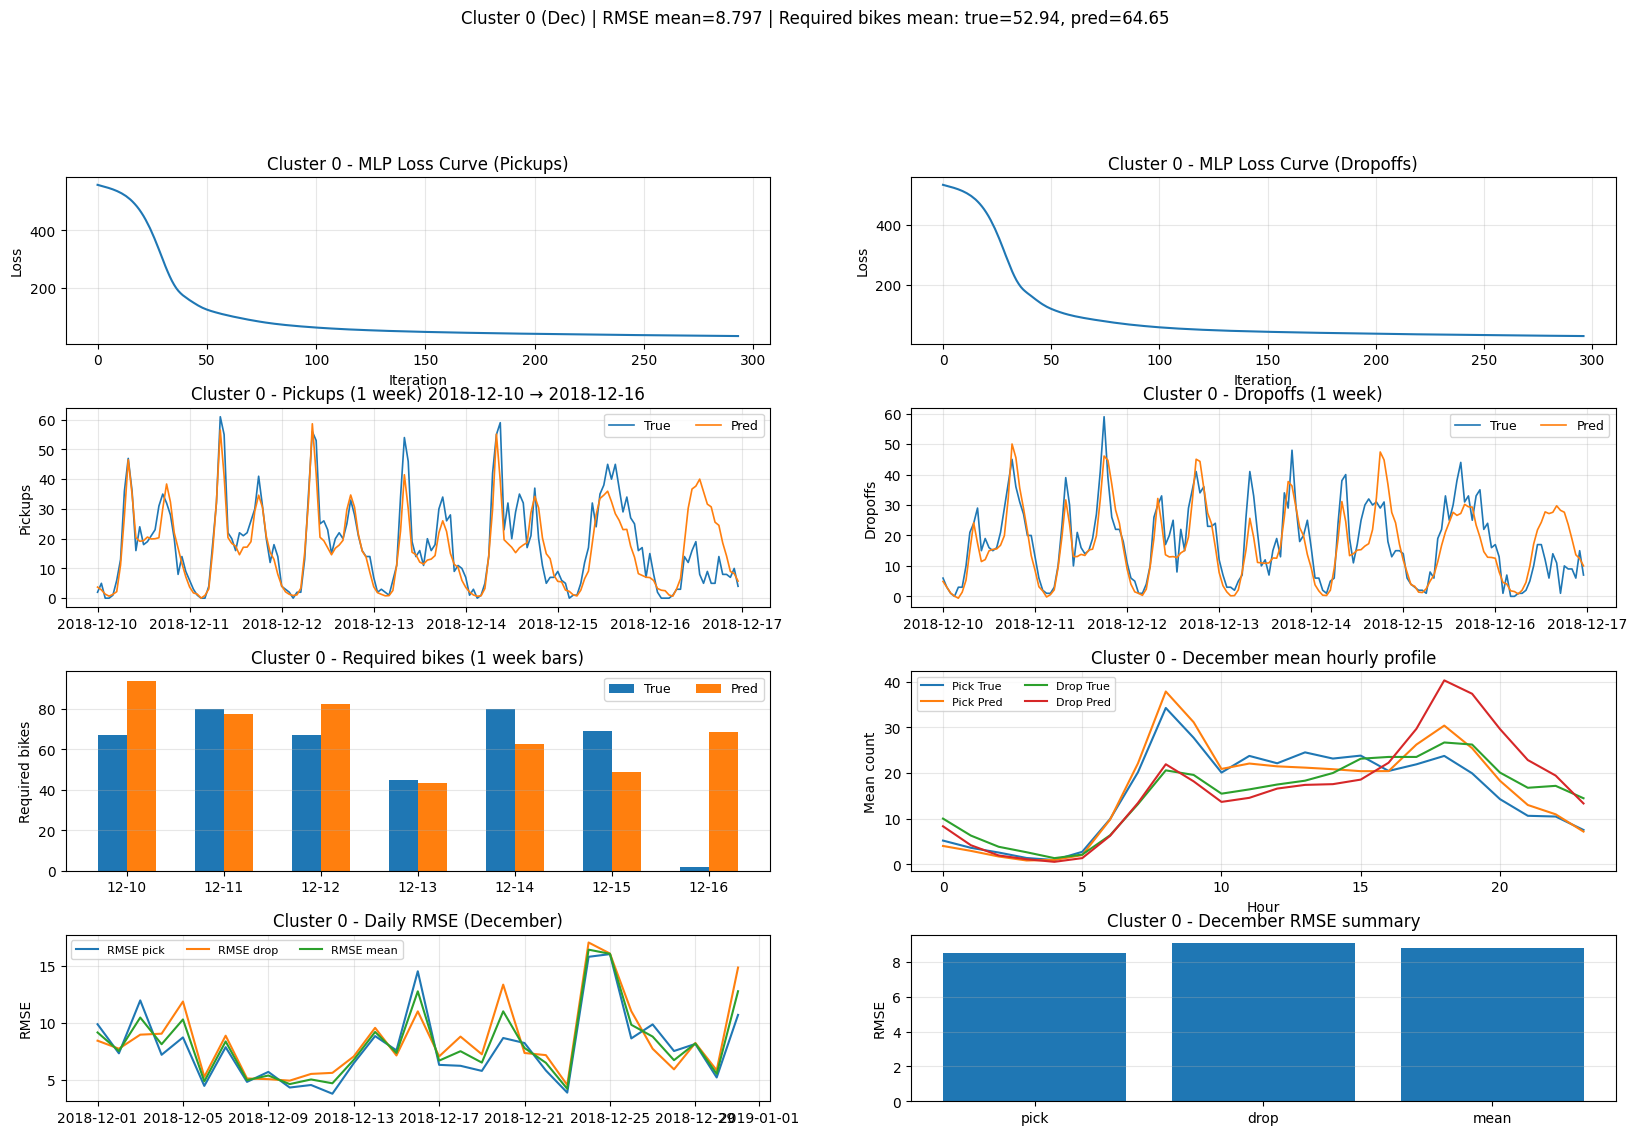

/tmp/ipykernel_117770/380540000.py:178: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


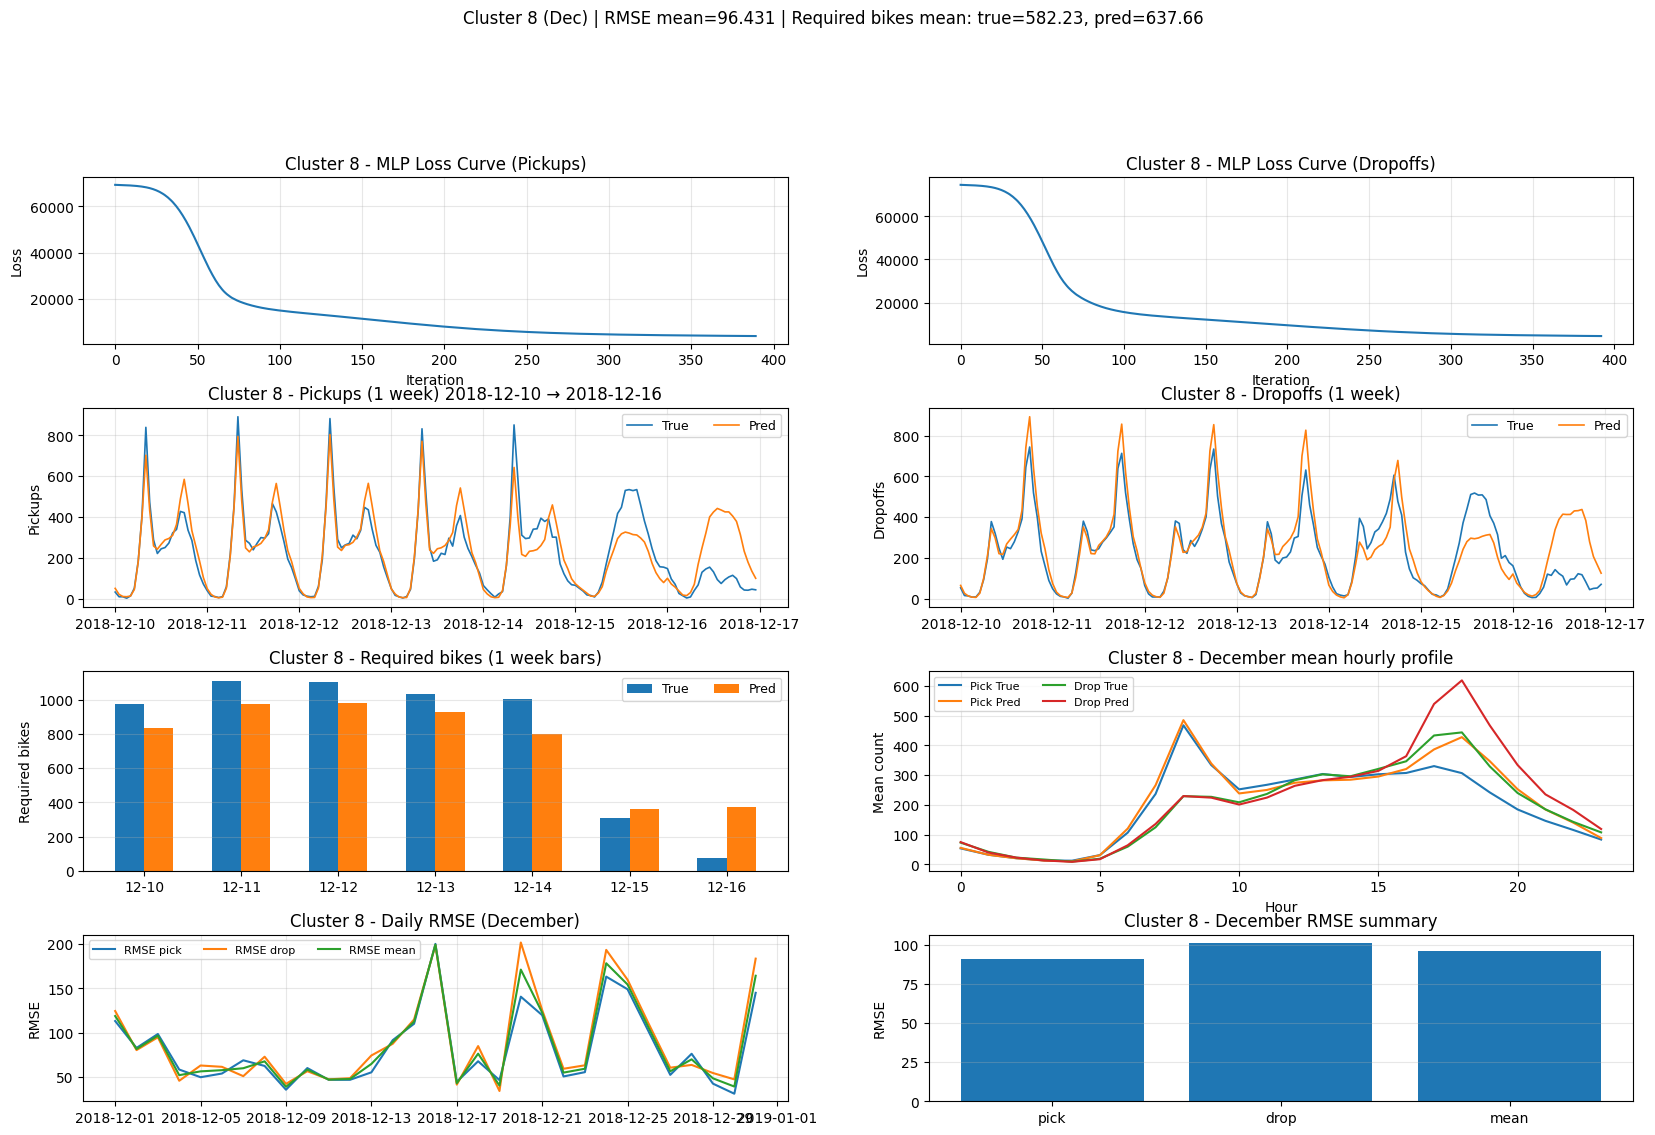

In [97]:
# Load predictions
out_all = load_all_cluster_outputs(CLUSTERS_TO_MODEL, PRED_DIR)

DEC_START = pd.Timestamp("2018-12-01")
DEC_END   = pd.Timestamp("2018-12-31 23:00:00")

# Pick a 1-week window in December (change if you want)
WEEK_START = pd.Timestamp("2018-12-10 00:00:00")
WEEK_END   = WEEK_START + pd.Timedelta(days=7)  # exclusive

TRUE_P = "y_true_pickups"
PRED_P = "y_pred_mlp_pickups"
TRUE_D = "y_true_dropoffs"
PRED_D = "y_pred_mlp_dropoffs"

for cid in CLUSTERS_TO_MODEL:
    dfc = out_all[(out_all["cluster_id"] == cid) & (out_all["split"] == "test")].copy()
    dfc = dfc[(dfc["timestamp"] >= DEC_START) & (dfc["timestamp"] <= DEC_END)]
    dfc = dfc.sort_values("timestamp")

    if dfc.empty:
        print(f"[WARN] No December test data for cluster {cid}")
        continue

    # ----- Load loss curves from artifacts -----
    art_path = ART_DIR / f"mlp_cluster_{cid}.joblib"
    artifact = joblib.load(art_path)
    loss_p = artifact.get("loss_curve_pickups", None)
    loss_d = artifact.get("loss_curve_dropoffs", None)

    # ----- 1-week window -----
    week = dfc[(dfc["timestamp"] >= WEEK_START) & (dfc["timestamp"] < WEEK_END)].copy()

    # ----- Monthly mean hourly profiles (Dec) -----
    mean_hour = (
        dfc.groupby("hour")[[TRUE_P, PRED_P, TRUE_D, PRED_D]]
        .mean()
        .reset_index()
        .sort_values("hour")
    )

    # ----- Required bikes daily (Dec) -----
    req_daily = daily_required_from_hourly_df(dfc, TRUE_P, TRUE_D, PRED_P, PRED_D)

    # Monthly mean required bikes (Dec)
    mean_req = req_daily[["required_true", "required_pred"]].mean()

    # ----- Daily RMSE (Dec) -----
    # pickup & drop computed on 24 hourly points per day
    dfc["day"] = dfc["timestamp"].dt.normalize()
    daily_metrics = []
    for day, g in dfc.groupby("day"):
        g = g.sort_values("hour")
        if len(g) < 24:
            continue
        rp = rmse(g[TRUE_P].values, g[PRED_P].values)
        rd = rmse(g[TRUE_D].values, g[PRED_D].values)
        daily_metrics.append((day, rp, rd, 0.5*(rp+rd)))
    daily_metrics = pd.DataFrame(daily_metrics, columns=["day", "rmse_pickups", "rmse_dropoffs", "rmse_mean"])

    # overall Dec RMSE
    rmse_pick = rmse(dfc[TRUE_P].values, dfc[PRED_P].values)
    rmse_drop = rmse(dfc[TRUE_D].values, dfc[PRED_D].values)
    rmse_avg  = 0.5*(rmse_pick + rmse_drop)

    # =========================
    # Compact plotting layout
    # =========================
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(4, 2, height_ratios=[1.0, 1.2, 1.2, 1.0], hspace=0.35, wspace=0.2)

    # (1) Loss curves
    ax = fig.add_subplot(gs[0, 0])
    if loss_p is not None:
        ax.plot(loss_p)
        ax.set_title(f"Cluster {cid} - MLP Loss Curve (Pickups)")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, "No loss curve saved", ha="center", va="center")
        ax.set_axis_off()

    ax = fig.add_subplot(gs[0, 1])
    if loss_d is not None:
        ax.plot(loss_d)
        ax.set_title(f"Cluster {cid} - MLP Loss Curve (Dropoffs)")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, "No loss curve saved", ha="center", va="center")
        ax.set_axis_off()

    # (2) One-week pickups (hourly timeline)
    ax = fig.add_subplot(gs[1, 0])
    if not week.empty:
        ax.plot(week["timestamp"], week[TRUE_P], label="True", linewidth=1.2)
        ax.plot(week["timestamp"], week[PRED_P], label="Pred", linewidth=1.2)
        ax.set_title(f"Cluster {cid} - Pickups (1 week) {WEEK_START.date()} → {(WEEK_END - pd.Timedelta(hours=1)).date()}")
        ax.set_ylabel("Pickups")
        ax.grid(True, alpha=0.3)
        ax.legend(ncol=2, fontsize=9)
    else:
        ax.text(0.5, 0.5, "Week window empty", ha="center", va="center")
        ax.set_axis_off()

    # (3) One-week dropoffs (hourly timeline)
    ax = fig.add_subplot(gs[1, 1])
    if not week.empty:
        ax.plot(week["timestamp"], week[TRUE_D], label="True", linewidth=1.2)
        ax.plot(week["timestamp"], week[PRED_D], label="Pred", linewidth=1.2)
        ax.set_title(f"Cluster {cid} - Dropoffs (1 week)")
        ax.set_ylabel("Dropoffs")
        ax.grid(True, alpha=0.3)
        ax.legend(ncol=2, fontsize=9)
    else:
        ax.text(0.5, 0.5, "Week window empty", ha="center", va="center")
        ax.set_axis_off()

    # (4) Required bikes bars (first 7 days of that week, compact)
    ax = fig.add_subplot(gs[2, 0])
    if not week.empty:
        req_week = daily_required_from_hourly_df(week, TRUE_P, TRUE_D, PRED_P, PRED_D)
        req_week = req_week.sort_values("day").head(7)
        x = np.arange(len(req_week))
        ax.bar(x - 0.15, req_week["required_true"].values, width=0.3, label="True")
        ax.bar(x + 0.15, req_week["required_pred"].values, width=0.3, label="Pred")
        ax.set_xticks(x)
        ax.set_xticklabels(req_week["day"].dt.strftime("%m-%d").values, rotation=0)
        ax.set_title(f"Cluster {cid} - Required bikes (1 week bars)")
        ax.set_ylabel("Required bikes")
        ax.legend(ncol=2, fontsize=9)
        ax.grid(True, axis="y", alpha=0.3)
    else:
        ax.text(0.5, 0.5, "Week window empty", ha="center", va="center")
        ax.set_axis_off()

    # (5) December mean hourly profile pickups+dropoffs (compact)
    ax = fig.add_subplot(gs[2, 1])
    ax.plot(mean_hour["hour"], mean_hour[TRUE_P], label="Pick True")
    ax.plot(mean_hour["hour"], mean_hour[PRED_P], label="Pick Pred")
    ax.plot(mean_hour["hour"], mean_hour[TRUE_D], label="Drop True")
    ax.plot(mean_hour["hour"], mean_hour[PRED_D], label="Drop Pred")
    ax.set_title(f"Cluster {cid} - December mean hourly profile")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Mean count")
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=2, fontsize=8)

    # (6) RMSE in test set (December): daily line + summary bars
    ax = fig.add_subplot(gs[3, 0])
    if not daily_metrics.empty:
        ax.plot(daily_metrics["day"], daily_metrics["rmse_pickups"], label="RMSE pick")
        ax.plot(daily_metrics["day"], daily_metrics["rmse_dropoffs"], label="RMSE drop")
        ax.plot(daily_metrics["day"], daily_metrics["rmse_mean"], label="RMSE mean")
        ax.set_title(f"Cluster {cid} - Daily RMSE (December)")
        ax.set_ylabel("RMSE")
        ax.grid(True, alpha=0.3)
        ax.legend(ncol=3, fontsize=8)
    else:
        ax.text(0.5, 0.5, "No daily metrics", ha="center", va="center")
        ax.set_axis_off()

    ax = fig.add_subplot(gs[3, 1])
    ax.bar(["pick", "drop", "mean"], [rmse_pick, rmse_drop, rmse_avg])
    ax.set_title(f"Cluster {cid} - December RMSE summary")
    ax.set_ylabel("RMSE")
    ax.grid(True, axis="y", alpha=0.3)

    # Add required bikes monthly mean as a tiny note
    fig.suptitle(
        f"Cluster {cid} (Dec) | RMSE mean={rmse_avg:.3f} | Required bikes mean: true={mean_req['required_true']:.2f}, pred={mean_req['required_pred']:.2f}",
        y=1.02,
        fontsize=12
    )

    plt.tight_layout()
    plt.show()


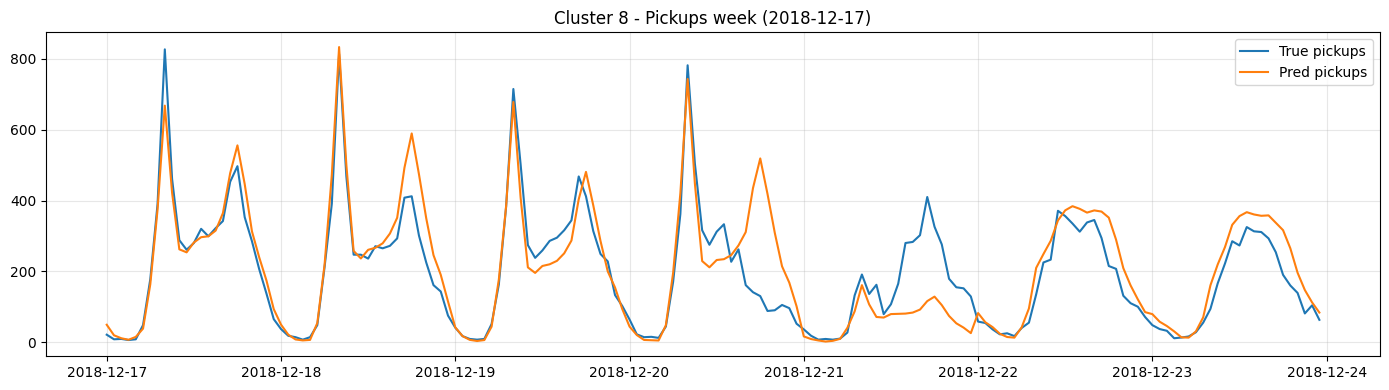

In [98]:
def plot_cluster_detail(out_all, cid, week_start="2018-12-10"):
    """Plot pickups over one week for a given cluster ID."""
    dfc = out_all[(out_all["cluster_id"] == cid) & (out_all["split"] == "test")].copy()
    dfc = dfc[(dfc["timestamp"] >= "2018-12-01") & (dfc["timestamp"] <= "2018-12-31 23:00:00")]
    dfc = dfc.sort_values("timestamp")
    week_start = pd.Timestamp(week_start)
    week_end = week_start + pd.Timedelta(days=7)
    week = dfc[(dfc["timestamp"] >= week_start) & (dfc["timestamp"] < week_end)].copy()

    fig, ax = plt.subplots(1, 1, figsize=(14, 4))
    ax.plot(week["timestamp"], week["y_true_pickups"], label="True pickups")
    ax.plot(week["timestamp"], week["y_pred_mlp_pickups"], label="Pred pickups")
    ax.set_title(f"Cluster {cid} - Pickups week ({week_start.date()})")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example:
plot_cluster_detail(out_all, 8, "2018-12-17")



GENERATING PLOTS FOR CLUSTER 0


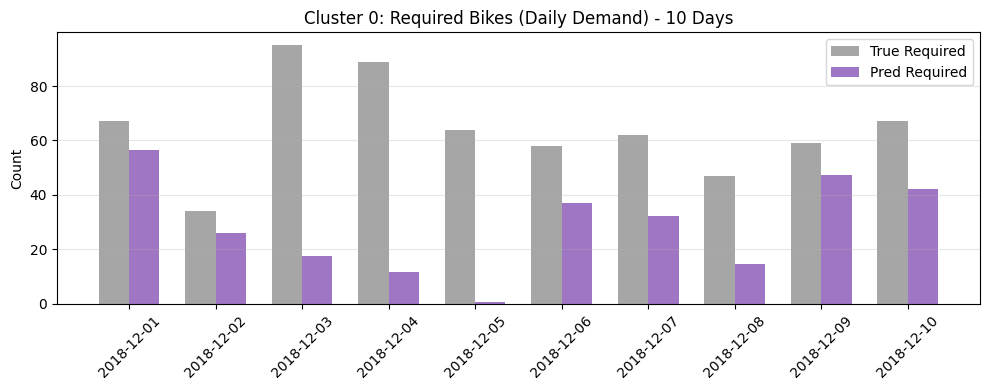


GENERATING PLOTS FOR CLUSTER 8


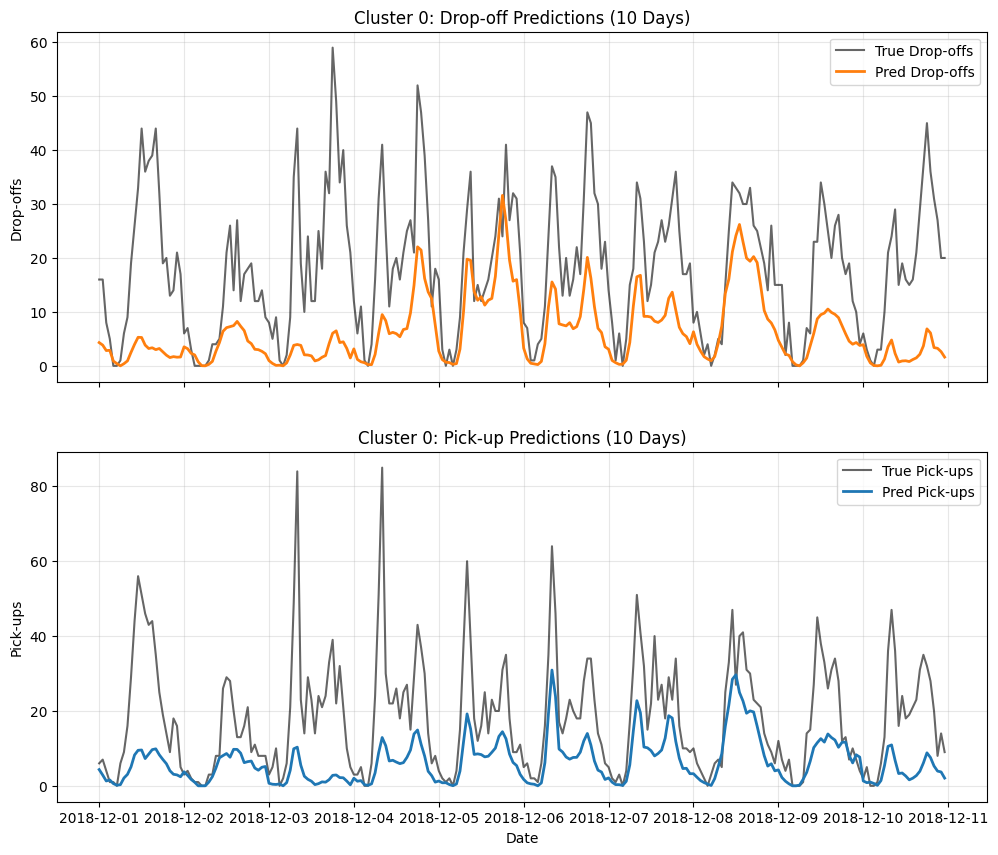

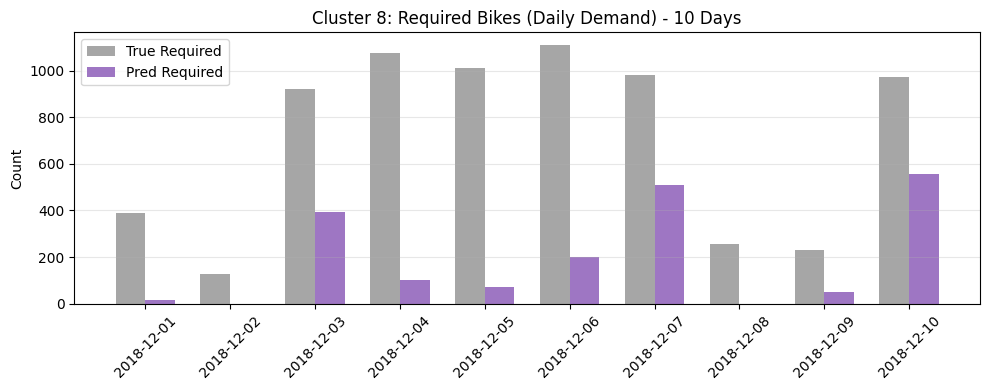

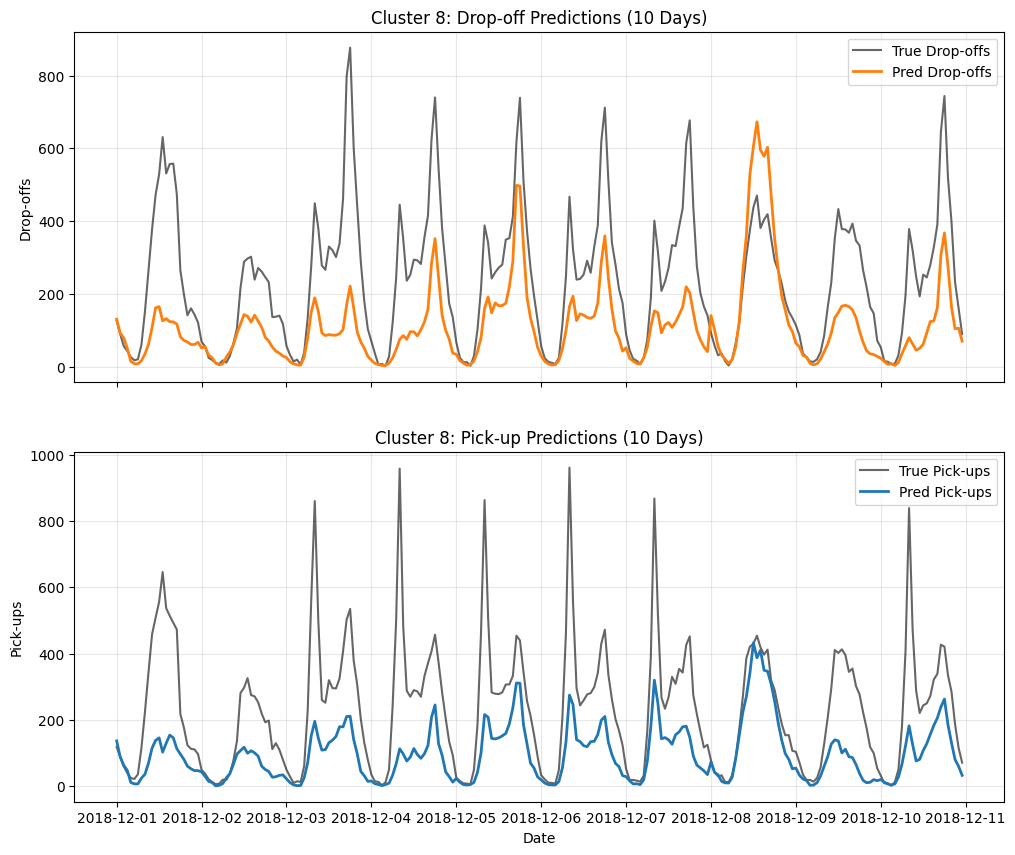

In [85]:
import matplotlib.dates as mdates

# Define the 10-day window for the time-series plots
PLOT_START = pd.Timestamp("2018-12-01")
PLOT_END   = PLOT_START + pd.Timedelta(days=10)

# Ensure data is loaded
out_all_analysis = load_all_cluster_outputs(CLUSTERS_TO_MODEL, PRED_DIR)

for cid in CLUSTERS_TO_MODEL:
    print(f"\n{'='*60}\nGENERATING PLOTS FOR CLUSTER {cid}\n{'='*60}")
    
    # --- Prepare Data ---
    # Filter for specific cluster and test split (December)
    dfc = out_all_analysis[(out_all_analysis["cluster_id"] == cid) & (out_all_analysis["split"] == "test")].copy()
    dfc = dfc.sort_values("timestamp")
    
    # Filter for the 10-day window
    mask_window = (dfc["timestamp"] >= PLOT_START) & (dfc["timestamp"] < PLOT_END)
    df_window = dfc[mask_window].copy()
    
    if df_window.empty:
        print(f"No data found for Cluster {cid} in window {PLOT_START} to {PLOT_END}")
        continue

    # Load artifacts for loss curves
    art_path = ART_DIR / f"mlp_cluster_{cid}.joblib"
    artifact = joblib.load(art_path)
    loss_p = artifact.get("loss_curve_pickups", [])
    loss_d = artifact.get("loss_curve_dropoffs", [])

    # Calculate required bikes for the window
    req_daily = daily_required_from_hourly_df(
        df_window, 
        "y_true_pickups", "y_true_dropoffs", 
        "y_pred_mlp_pickups", "y_pred_mlp_dropoffs"
    )

    # --- Generate 5 Separate Plots ---

    # # 1. Training Loss - Drop-offs
    # plt.figure(figsize=(10, 4))
    # plt.plot(loss_d, color='tab:orange', label='Drop-off Loss')
    # plt.title(f"Cluster {cid}: Training Loss (Drop-offs)")
    # plt.xlabel("Iteration")
    # plt.ylabel("Loss")
    # plt.legend()
    # plt.grid(True, alpha=0.3)
    # plt.show()

    # # 2. Training Loss - Pick-ups
    # plt.figure(figsize=(10, 4))
    # plt.plot(loss_p, color='tab:blue', label='Pick-up Loss')
    # plt.title(f"Cluster {cid}: Training Loss (Pick-ups)")
    # plt.xlabel("Iteration")
    # plt.ylabel("Loss")
    # plt.legend()
    # plt.grid(True, alpha=0.3)
    # plt.show()

    # 3. Demand Prediction Bar Plot (Required Bikes)
    plt.figure(figsize=(10, 4))
    x_indexes = np.arange(len(req_daily))
    width = 0.35
    plt.bar(x_indexes - width/2, req_daily["required_true"], width, label='True Required', color='grey', alpha=0.7)
    plt.bar(x_indexes + width/2, req_daily["required_pred"], width, label='Pred Required', color='tab:purple', alpha=0.9)
    plt.xticks(x_indexes, req_daily["day"].dt.strftime('%Y-%m-%d'), rotation=45)
    plt.title(f"Cluster {cid}: Required Bikes (Daily Demand) - 10 Days")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

        # 4. Combined 10 Days Prediction (Drop-offs and Pick-ups)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Subplot 1: Drop-offs
    ax1.plot(df_window["timestamp"], df_window["y_true_dropoffs"], label="True Drop-offs", color='black', alpha=0.6)
    ax1.plot(df_window["timestamp"], df_window["y_pred_mlp_dropoffs"], label="Pred Drop-offs", color='tab:orange', linewidth=2)
    ax1.set_title(f"Cluster {cid}: Drop-off Predictions (10 Days)")
    ax1.set_ylabel("Drop-offs")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Subplot 2: Pick-ups
    ax2.plot(df_window["timestamp"], df_window["y_true_pickups"], label="True Pick-ups", color='black', alpha=0.6)
    ax2.plot(df_window["timestamp"], df_window["y_pred_mlp_pickups"], label="Pred Pick-ups", color='tab:blue', linewidth=2)
    ax2.set_title(f"Cluster {cid}: Pick-up Predictions (10 Days)")
    ax2.set_ylabel("Pick-ups")
    ax2.set_xlabel("Date")
    ax2.legend()
    ax2.grid(True, alpha=0.3)